# Demographic Information
1. Gender Ratio
2. Age Distribution
3. Proportions of Drinking and Smoking

In [1]:
import pandas as pd
df = pd.read_csv('/home/ubuntu/proj/rt-dataset/src/data/demographic.csv')
df = df[['export_id', 'age', 'gender', 'edu', 'smoke', 'drink']]
df['age'] = pd.to_numeric(df['age'], errors='coerce')

print(f'Number of rows: {df.shape[0]}')
print(f'Gender: \n{df.gender.value_counts()}')
print(f'Age: \nmean: {df.age.mean()} \nstd: {df.age.std()}')
df.head()

Number of rows: 24292
Gender: 
gender
female    15545
male       8747
Name: count, dtype: int64
Age: 
mean: 20.65573028157418 
std: 2.4087126611000023


,export_id,age,gender,edu,smoke,drink
0,61793,19.0,female,bachelor's degree,never smokes,never drinks
1,61809,18.0,female,bachelor's degree,never smokes,never drinks
2,61737,40.0,male,master's degree,never smokes,drinks occasionally (less than once a week)
3,61738,23.0,female,bachelor's degree,never smokes,never drinks
4,61739,21.0,female,bachelor's degree,never smokes,never drinks


# Scale Scores
1. Distribution of Scale Scores
2. Correlation Between Different Scale Scores

In [1]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns

from data import Data

%config InlineBackend.figure_format = 'retina'

scale_list = ['phq9', 'isi', 'gad7', 'pss']
phq9, gad7, isi, pss = Data('phq9', is_remove_outlier=True), \
    Data('gad7', is_remove_outlier=True), \
        Data('isi', is_remove_outlier=True), \
            Data('pss', is_remove_outlier=True)

<AxesSubplot:xlabel='total_time', ylabel='Count'>

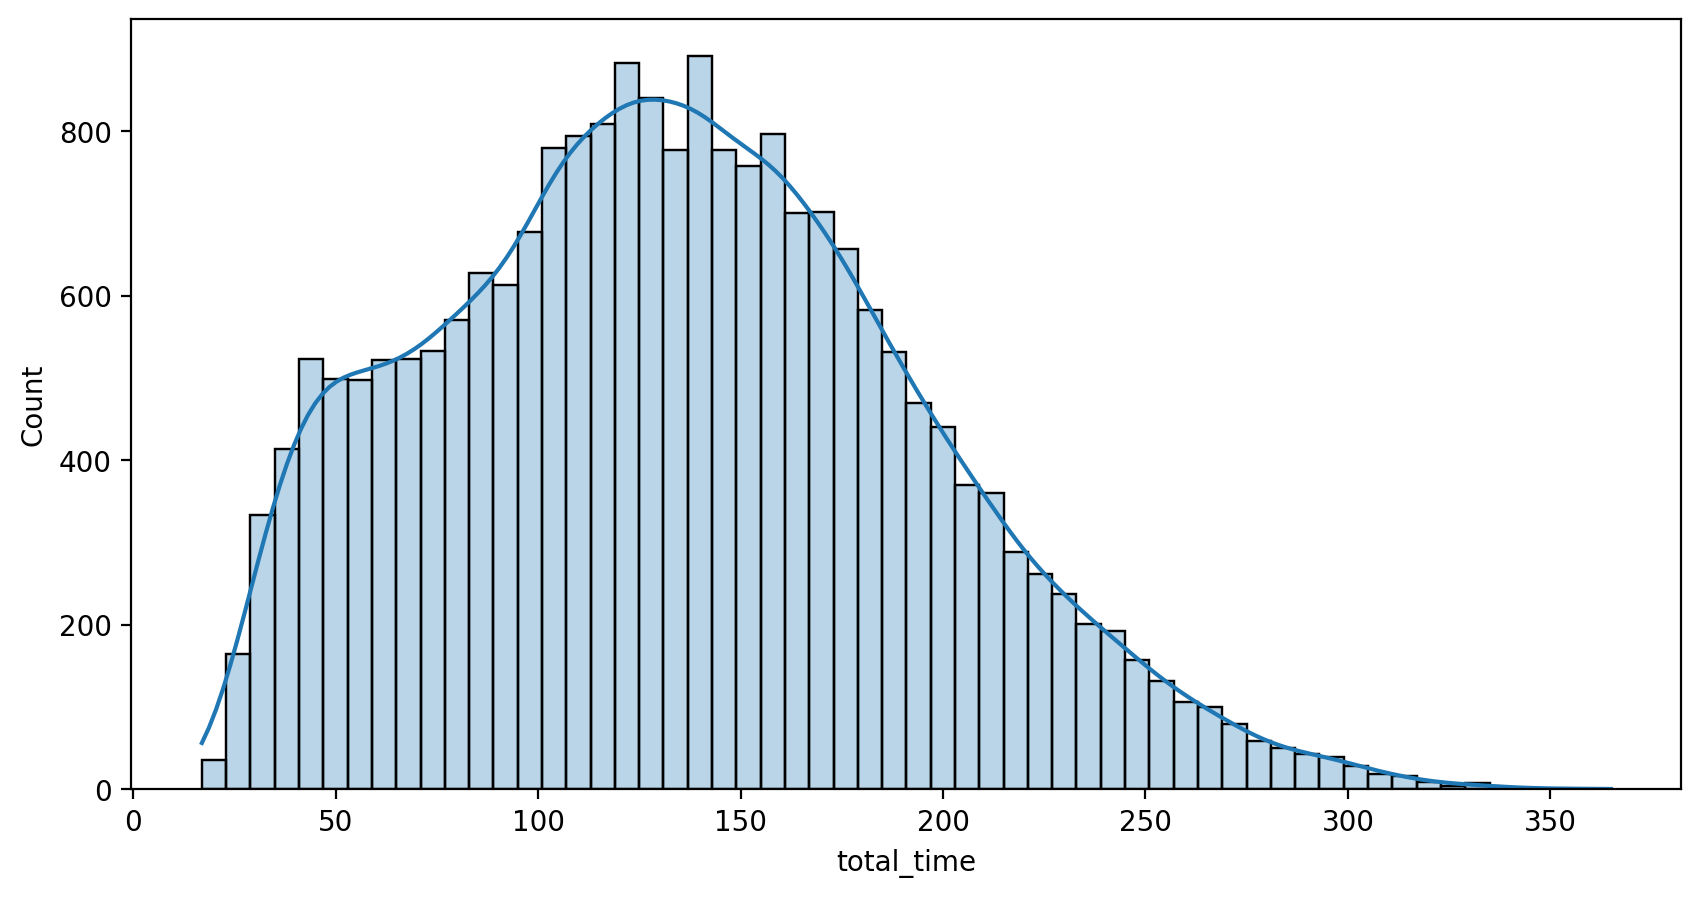

In [2]:
rename_and_select = lambda scale, df: df.rename(columns={
    'total_response_time': f'total_{scale}_time'
    })[['export_id', f'total_{scale}_time']]

scales = {
    'phq9': phq9.df,
    'gad7': gad7.df,
    'isi': isi.df,
    'pss': pss.df
}

merged_df = pd.concat([rename_and_select(scale, df) for scale, df in scales.items()], axis=1, join='inner')
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]

total_time_cols = [col for col in merged_df.columns if col.startswith('total_')]
merged_df['total_time'] = merged_df[total_time_cols].sum(axis=1)
filtered_df = merged_df[merged_df['total_time'] < 700]

# plot
plt.figure(figsize=(10, 5))
sns.histplot(data=filtered_df, x='total_time', alpha=0.3, kde=True)

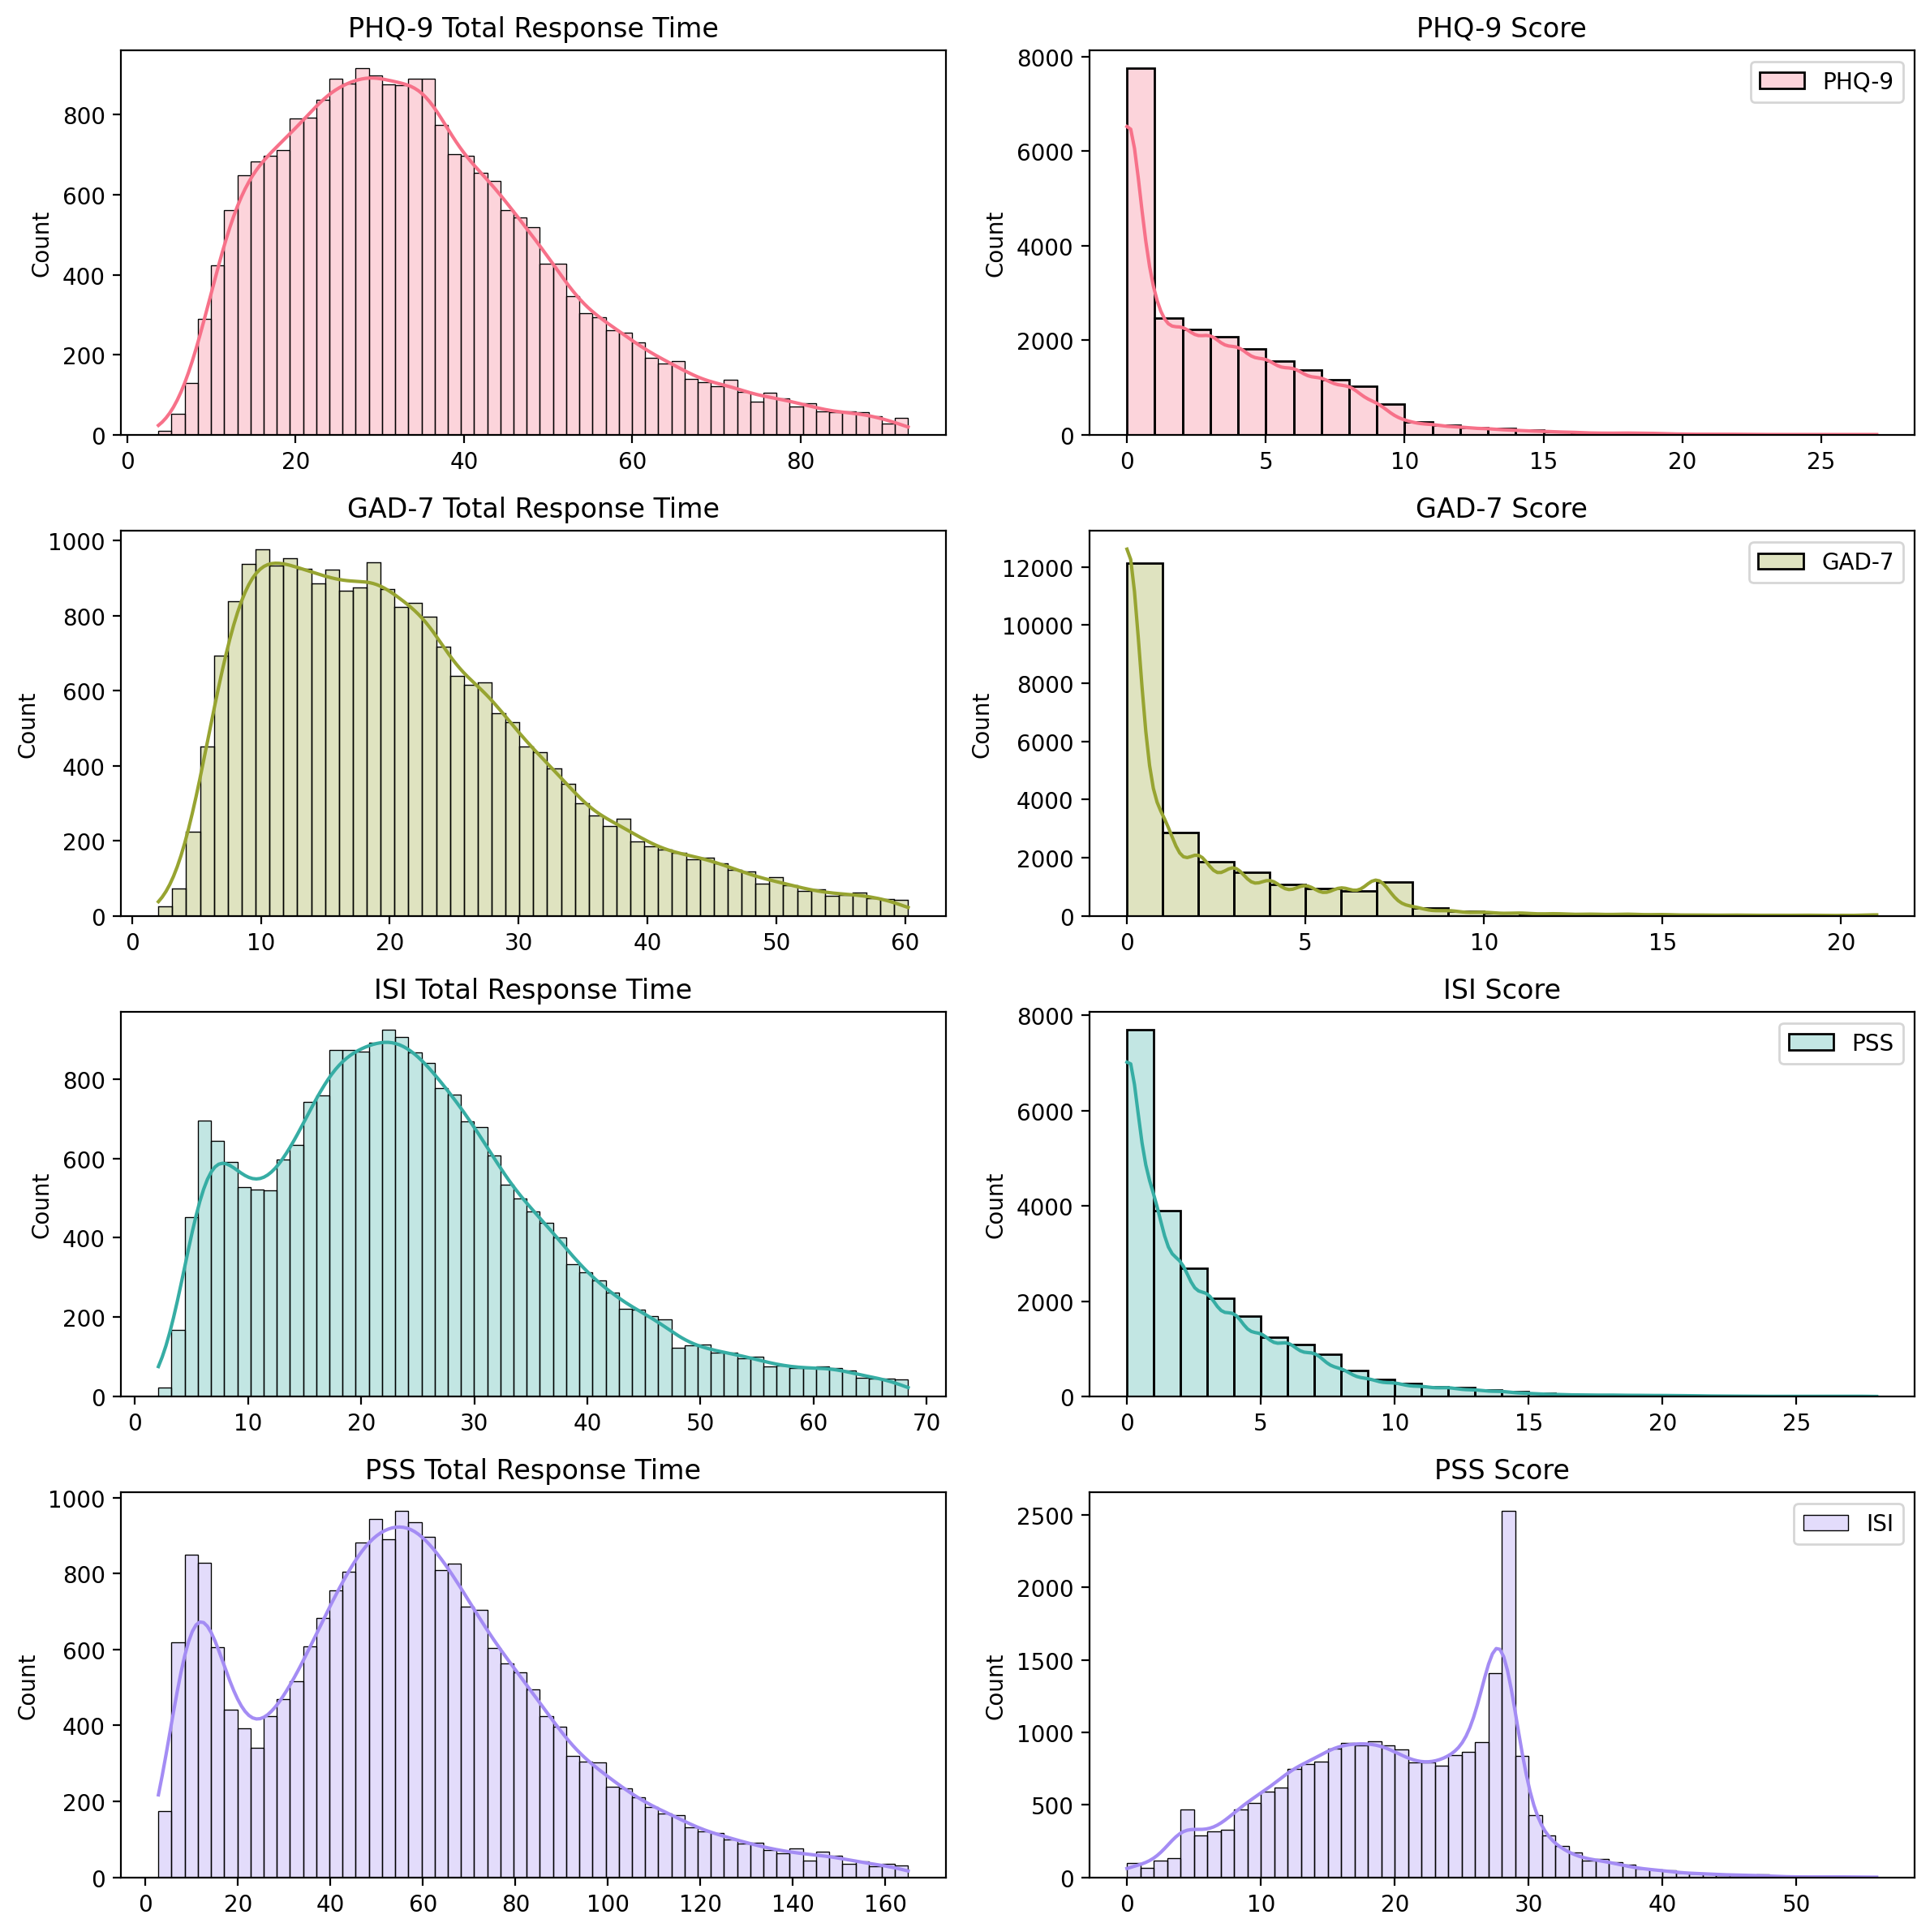

In [6]:
fig, ax = plt.subplots(4, 2, figsize=(12, 12))
ax = ax.flatten()
palette = sns.color_palette("husl", 4)
labels = ['PHQ-9', 'GAD-7', 'PSS', 'ISI']

sns.histplot(data=phq9.df, x='total_response_time', alpha=0.3, kde=True, color=palette[0], label=labels[0], ax=ax[0])
sns.histplot(data=phq9.df, x='score', alpha=0.3, kde=True, color=palette[0], bins=27, label=labels[0], ax=ax[1])
ax[0].set_title('PHQ-9 Total Response Time')
ax[0].set_xlabel('')
ax[1].set_title('PHQ-9 Score')
ax[1].set_xlabel('')
ax[1].legend()
sns.histplot(data=gad7.df, x='total_response_time', alpha=0.3, kde=True, color=palette[1], label=labels[1], ax=ax[2])
sns.histplot(data=gad7.df, x='score', alpha=0.3, kde=True, color=palette[1], bins=21, label=labels[1], ax=ax[3])
ax[2].set_title('GAD-7 Total Response Time')
ax[2].set_xlabel('')
ax[3].set_title('GAD-7 Score')
ax[3].set_xlabel('')
ax[3].legend()
sns.histplot(data=isi.df, x='total_response_time', alpha=0.3, kde=True, color=palette[2], label=labels[2], ax=ax[4])
sns.histplot(data=isi.df, x='score', alpha=0.3, kde=True, color=palette[2], bins=28, label=labels[2], ax=ax[5])
ax[4].set_title('ISI Total Response Time')
ax[4].set_xlabel('')
ax[5].set_title('ISI Score')
ax[5].set_xlabel('')
ax[5].legend()
sns.histplot(data=pss.df, x='total_response_time', alpha=0.3, kde=True, color=palette[3], label=labels[3], ax=ax[6])
sns.histplot(data=pss.df, x='score', alpha=0.3, kde=True, color=palette[3], bins=56, label=labels[3], ax=ax[7])
ax[6].set_title('PSS Total Response Time')
ax[6].set_xlabel('')
ax[7].set_title('PSS Score')
ax[7].set_xlabel('')
ax[7].legend()

plt.tight_layout()
plt.show()


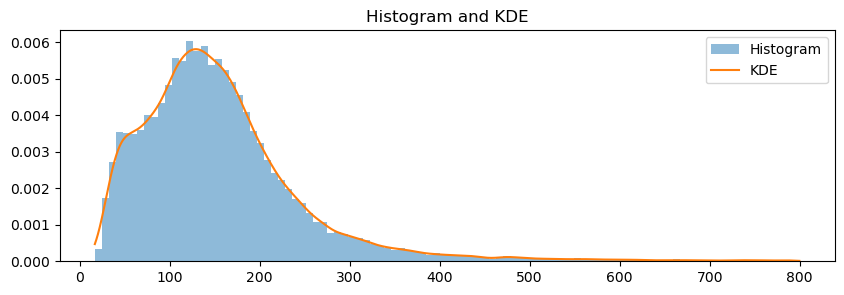

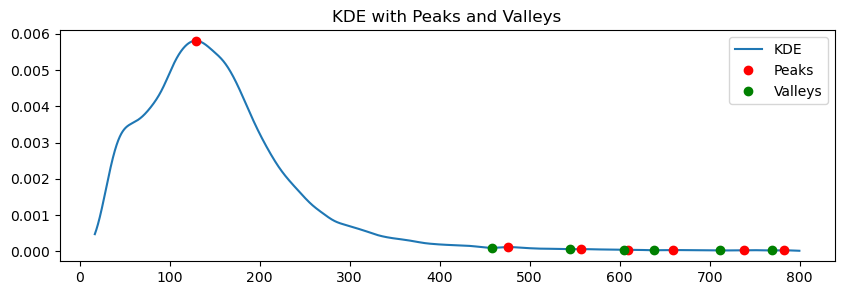

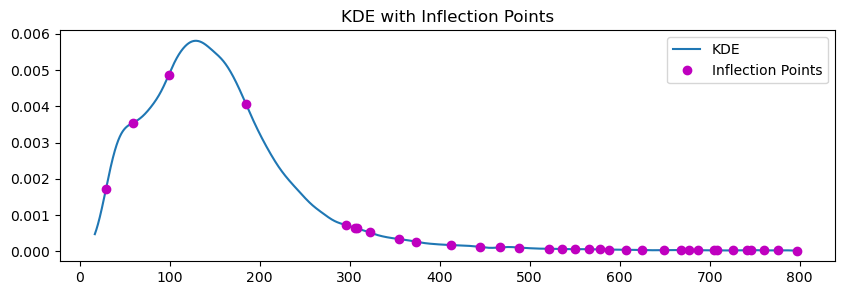

拐点的x值: [29.25773477 59.0770147  98.91432043]


In [52]:
data = df['total_time'].values

kde = gaussian_kde(data, bw_method=0.1)
x = np.linspace(min(data), max(data), 10000)
kde_values = kde(x)

# 绘制直方图和核密度估计图
plt.figure(figsize=(10, 3))
plt.hist(data, bins=100, density=True, alpha=0.5, label='Histogram')
plt.plot(x, kde_values, label='KDE')
plt.legend()
plt.title('Histogram and KDE')
plt.show()

# 计算一阶导数
first_derivative = np.gradient(kde_values, x)

# 找到峰值
peaks, _ = find_peaks(kde_values)
valleys, _ = find_peaks(-kde_values)

# 绘制核密度估计图和峰值
plt.figure(figsize=(10, 3))
plt.plot(x, kde_values, label='KDE')
plt.plot(x[peaks], kde_values[peaks], 'ro', label='Peaks')
plt.plot(x[valleys], kde_values[valleys], 'go', label='Valleys')
plt.legend()
plt.title('KDE with Peaks and Valleys')
plt.show()

# 计算二阶导数
second_derivative = np.gradient(first_derivative, x)

# 找到拐点
inflection_points = np.where(np.diff(np.sign(second_derivative)))[0]
inflection_x = x[inflection_points]

# 绘制核密度估计图和拐点
plt.figure(figsize=(10, 3))
plt.plot(x, kde_values, label='KDE')
plt.plot(x[inflection_points], kde_values[inflection_points], 'mo', label='Inflection Points')
plt.legend()
plt.title('KDE with Inflection Points')
plt.show()

# 打印拐点的x值
print("拐点的x值:", inflection_x[:3])

In [11]:
def statsum(df, name):

    print(f'After remove CR, {name} score')
    print(f'mean: {np.mean(df.score)}')
    print(f'std: {np.std(df.score)}')

    print(f'After remove CR, {name} total response time')
    print(f'mean: {np.mean(df.total_response_time)}')
    print(f'std: {np.std(df.total_response_time)}')

statsum(phq9.df.query('is_careless_response == False'), 'PHQ-9')
statsum(gad7.df.query('is_careless_response == False'), 'GAD-7')
statsum(isi.df.query('is_careless_response == False'), 'ISI')
statsum(pss.df.query('is_careless_response == False'), 'PSS')

After remove CR, PHQ-9 score
mean: 3.4189619377162628
std: 3.697865007293027
After remove CR, PHQ-9 total response time
mean: 37.471362399077364
std: 17.299654252958213
After remove CR, GAD-7 score
mean: 2.1772998927312663
std: 2.9877719160333753
After remove CR, GAD-7 total response time
mean: 25.306817694233022
std: 12.509679105214508
After remove CR, ISI score
mean: 2.9389233954451344
std: 3.442613627397756
After remove CR, ISI total response time
mean: 28.474790002957686
std: 13.202734706843838
After remove CR, PSS score
mean: 18.72322934232715
std: 8.329103621820165
After remove CR, PSS total response time
mean: 63.88724810286692
std: 26.300214970580097


In [13]:
import pandas as pd
from scipy.stats import pearsonr
from itertools import combinations


def merge(df_list, on='export_id'):
    df = df_list[0]
    for i in range(1, len(df_list)):
        df = pd.merge(df, df_list[i], on=on)
    return df

# is_careless_response == False
df_list = [phq9.df[['export_id', 'score']], \
           gad7.df[['export_id', 'score']], \
            isi.df[['export_id', 'score']], \
            pss.df[['export_id', 'score']]]

# df_list = [phq9.df[['export_id', 'score']], \
#               gad7.df[['export_id', 'score']], \
#                 isi.df[['export_id', 'score']], \
#                 pss.df[['export_id', 'score']]]

df = merge(df_list).drop(columns=['export_id'])

# rename columns
df.columns = ['phq9', 'gad7', 'isi', 'pss']

corr = pd.DataFrame(columns=['phq9', 'gad7', 'isi', 'pss'], index=['phq9', 'gad7', 'isi', 'pss'])

# calculate correlation
for column1, column2 in combinations(df.columns, 2):
    r, p = pearsonr(df[column1], df[column2])
    if p < 0.0001:
        corr.loc[column2, column1] = str(round(r, 3)) + '***'
    elif p < 0.001:
        corr.loc[column2, column1] = str(round(r, 3)) + '**'
    elif p < 0.01:
        corr.loc[column2, column1] = str(round(r, 3)) + '*'

corr.to_csv('results/correlation.csv')

/tmp/ipykernel_3616575/2746536402.py:9: FutureWarning: Passing 'suffixes' which cause duplicate columns {'score_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, df_list[i], on=on)
